In [1]:
from datascience import *
%matplotlib inline
path_data = '../../assets/data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import numpy as np
from scipy import stats

# Correlation

In this section we will develop a measure of how tightly clustered a scatter diagram is about a straight line. Formally, this is called measuring *linear association*.

In [2]:
def r_scatter(r):
    plots.figure(figsize=(5,5))
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    plots.scatter(x, y)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)

The table `hybrid` contains data on hybrid passenger cars sold in the United States from 1997 to 2013. The data were adapted from the online data archive of [Prof. Larry Winner](http://www.stat.ufl.edu/%7Ewinner/) of the University of Florida. The columns:

- `vehicle`: model of the car
- `year`: year of manufacture
- `msrp`: manufacturer's suggested retail price in 2013 dollars
- `acceleration`: acceleration rate in km per hour per second
- `mpg`: fuel econonmy in miles per gallon
- `class`: the model's class.

In [3]:
hybrid = Table.read_table(path_data + 'hybrid.csv')

In [4]:
hybrid

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact
Insight,2001,19036.7,9.52,53,Two Seater
Insight,2002,19137,9.71,53,Two Seater
Alphard,2003,38084.8,8.33,40.46,Minivan
Insight,2003,19137,9.52,53,Two Seater
Civic,2003,14071.9,8.62,41,Compact


The graph below is a scatter plot of `msrp` *versus* `acceleration`. That means `msrp` is plotted on the vertical axis and `accelaration` on the horizontal.

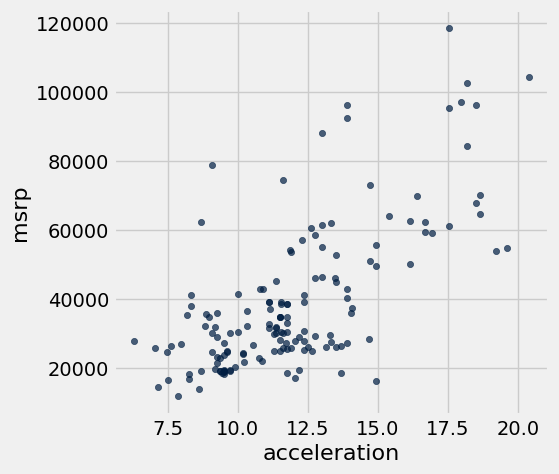

In [5]:
hybrid.scatter('acceleration', 'msrp')

Notice the positive association. The scatter of points is sloping upwards, indicating that cars with greater acceleration tended to cost more, on average; conversely, the cars that cost more tended to have greater acceleration on average. 

The scatter diagram of MSRP versus mileage shows a negative association. Hybrid cars with higher mileage tended to cost less, on average. This seems surprising till you consider that cars that accelerate fast tend to be less fuel efficient and have lower mileage. As the previous scatter plot showed, those were also the cars that tended to cost more. 

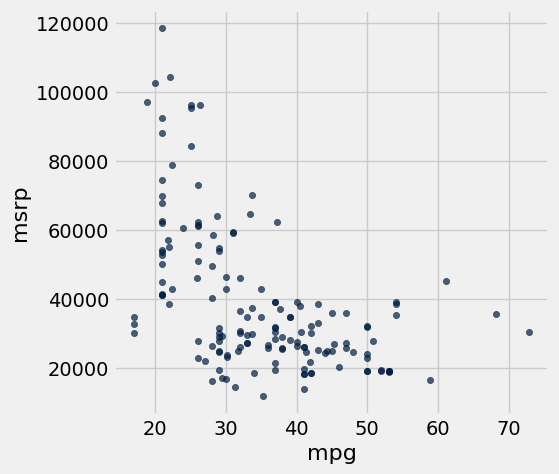

In [6]:
hybrid.scatter('mpg', 'msrp')

Along with the negative association, the scatter diagram of price versus efficiency shows a non-linear relation between the two variables. The points appear to be clustered around a curve, not around a straight line. 

If we restrict the data just to the SUV class, however, the association between price and efficiency is still negative but the relation appears to be more linear. The relation between the price and acceleration of SUV's also shows a linear trend, but with a positive slope.

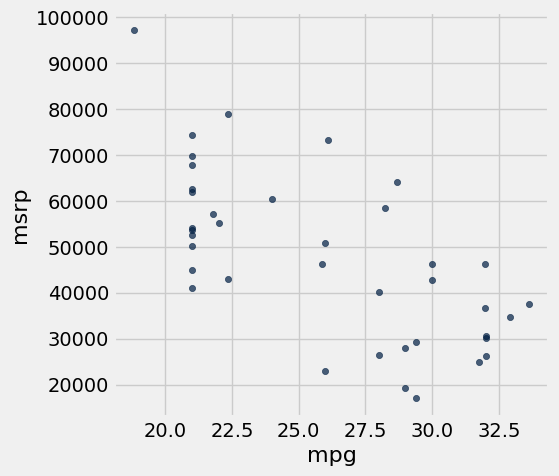

In [7]:
suv = hybrid.where('class', 'SUV')
suv.scatter('mpg', 'msrp')

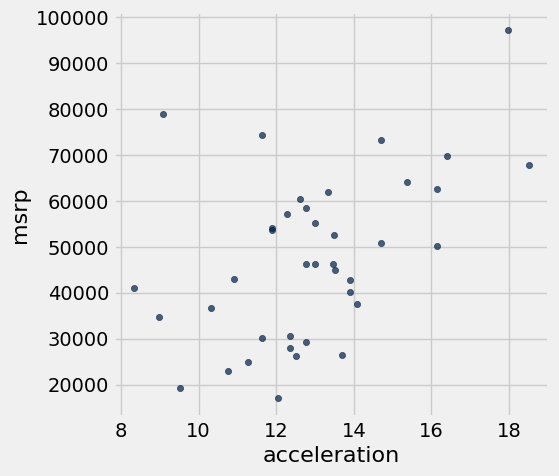

In [8]:
suv.scatter('acceleration', 'msrp')

You will have noticed that we can derive useful information from the general orientation and shape of a scatter diagram even without paying attention to the units in which the variables were measured.

Indeed, we could plot all the variables in standard units and the plots would look the same. This gives us a way to compare the degree of linearity in two scatter diagrams.

Recall that in an earlier section we defined the function `standard_units` to convert an array of numbers to standard units.

In [9]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

We can use this function to re-draw the two scatter diagrams for SUVs, with all the variables measured in standard units.

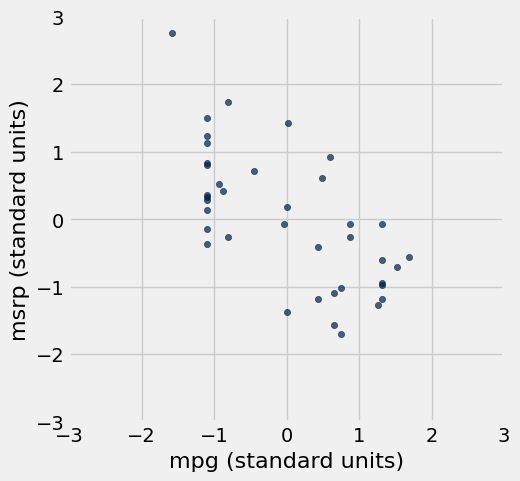

In [10]:
Table().with_columns(
    'mpg (standard units)',  standard_units(suv.column('mpg')), 
    'msrp (standard units)', standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

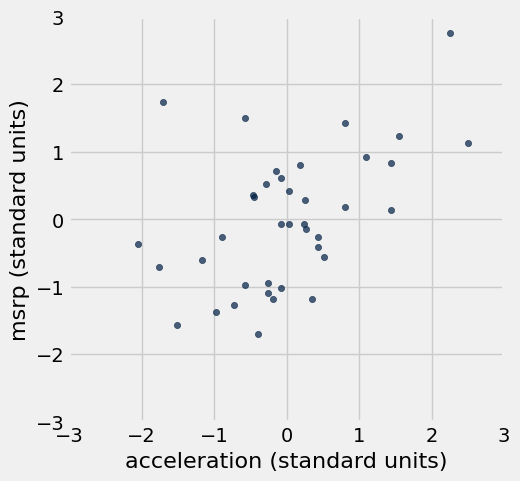

In [11]:
Table().with_columns(
    'acceleration (standard units)', standard_units(suv.column('acceleration')), 
    'msrp (standard units)',         standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

The associations that we see in these figures are the same as those we saw before. Also, because the two scatter diagrams are now drawn on exactly the same scale, we can see that the linear relation in the second diagram is a little more fuzzy than in the first.

We will now define a measure that uses standard units to quantify the kinds of association that we have seen.

## The correlation coefficient

The *correlation coefficient* measures the strength of the linear relationship between two variables. Graphically, it measures how clustered the scatter diagram is around a straight line.

The term *correlation coefficient* isn't easy to say, so it is usually shortened to *correlation* and denoted by $r$.

Here are some mathematical facts about $r$ that we will just observe by simulation.

- The correlation coefficient $r$ is a number between $-1$ and 1.
- $r$ measures the extent to which the scatter plot clusters around a straight line.
- $r = 1$ if the scatter diagram is a perfect straight line sloping upwards, and $r = -1$ if the scatter diagram is a perfect straight line sloping downwards.

The function ``r_scatter`` takes a value of $r$ as its argument and simulates a scatter plot with a correlation very close to $r$. Because of randomness in the simulation, the correlation is not expected to be exactly equal to $r$.

Call ``r_scatter`` a few times, with different values of $r$ as the argument, and see how the scatter plot changes. 

When $r=1$ the scatter plot is perfectly linear and slopes upward. When $r=-1$, the scatter plot is perfectly linear and slopes downward. When $r=0$, the scatter plot is a formless cloud around the horizontal axis, and the variables are said to be *uncorrelated*.

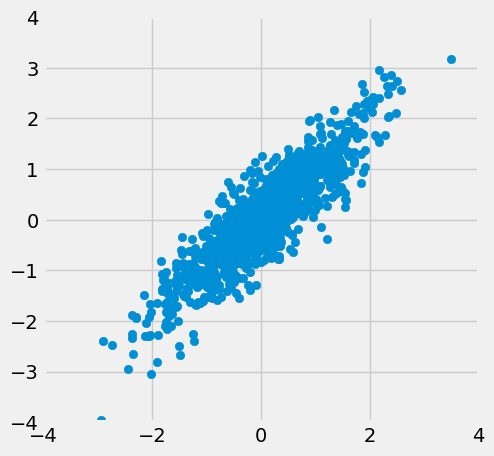

In [12]:
r_scatter(0.9)

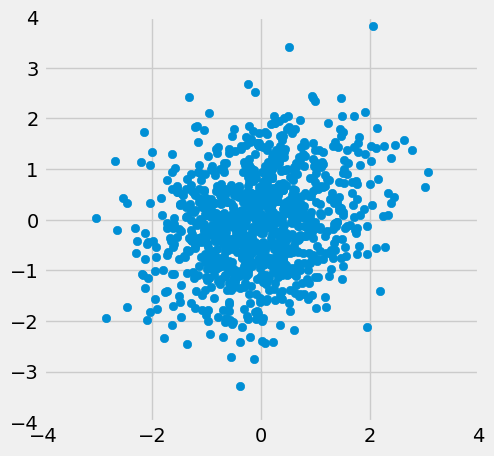

In [13]:
r_scatter(0.25)

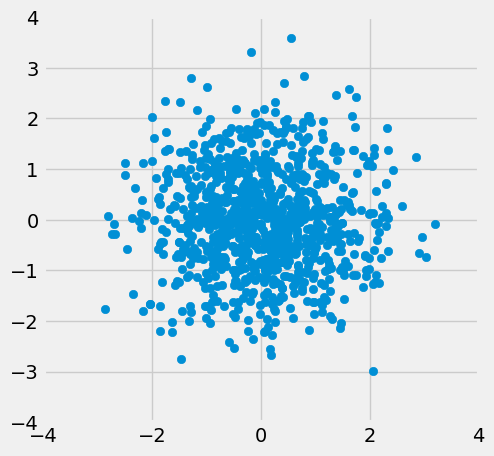

In [14]:
r_scatter(0)

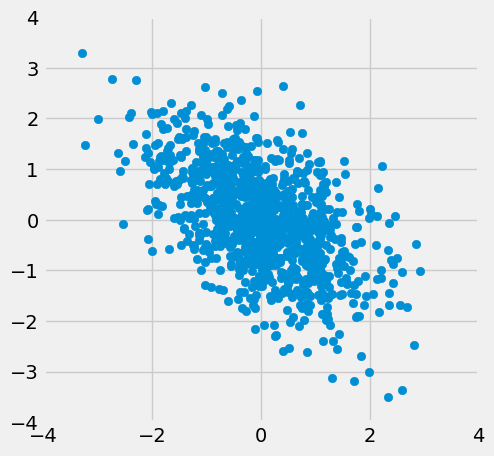

In [15]:
r_scatter(-0.55)

## Calculating $r$

The formula for $r$ is not apparent from our observations so far. It has a mathematical basis that is outside the scope of this class. However, as you will see, the calculation is straightforward and helps us understand several of the properties of $r$.

**Formula for $r$**:

**$r$ is the average of the products of the two variables, when both variables are measured in standard units.**

Here are the steps in the calculation. We will apply the steps to a simple table of values of $x$ and $y$.

In [16]:
x = np.arange(1, 7, 1)
y = make_array(2, 3, 1, 5, 2, 7)
t = Table().with_columns(
        'x', x,
        'y', y
    )
t

x,y
1,2
2,3
3,1
4,5
5,2
6,7


Based on the scatter diagram, we expect that $r$ will be positive but not equal to 1.

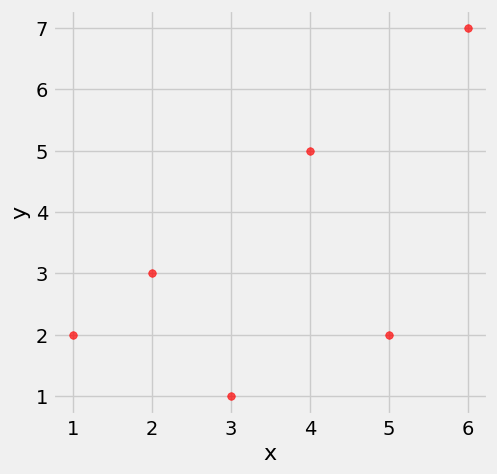

In [17]:
t.scatter(0, 1, s=30, color='red')

**Step 1.** Convert each variable to standard units.

In [18]:
t_su = t.with_columns(
        'x (standard units)', standard_units(x),
        'y (standard units)', standard_units(y)
    )
t_su

x,y,x (standard units),y (standard units)
1,2,-1.46385,-0.648886
2,3,-0.87831,-0.162221
3,1,-0.29277,-1.13555
4,5,0.29277,0.811107
5,2,0.87831,-0.648886
6,7,1.46385,1.78444


**Step 2.** Multiply each pair of standard units.

In [19]:
t_product = t_su.with_column('product of standard units', t_su.column(2) * t_su.column(3))
t_product

x,y,x (standard units),y (standard units),product of standard units
1,2,-1.46385,-0.648886,0.949871
2,3,-0.87831,-0.162221,0.142481
3,1,-0.29277,-1.13555,0.332455
4,5,0.29277,0.811107,0.237468
5,2,0.87831,-0.648886,-0.569923
6,7,1.46385,1.78444,2.61215


**Step 3.** $r$ is the average of the products computed in Step 2.

In [20]:
# r is the average of the products of standard units

r = np.mean(t_product.column(4))
r

0.61741639718977093

As expected, $r$ is positive but not equal to 1.

## Properties of $r$

The calculation shows that:

- $r$ is a pure number. It has no units. This is because $r$ is based on standard units.
- $r$ is unaffected by changing the units on either axis. This too is because $r$ is based on standard units.
- $r$ is unaffected by switching the axes. Algebraically, this is because the product of standard units does not depend on which variable is called $x$ and which $y$. Geometrically, switching axes reflects the scatter plot about the line $y=x$, but does not change the amount of clustering nor the sign of the association.

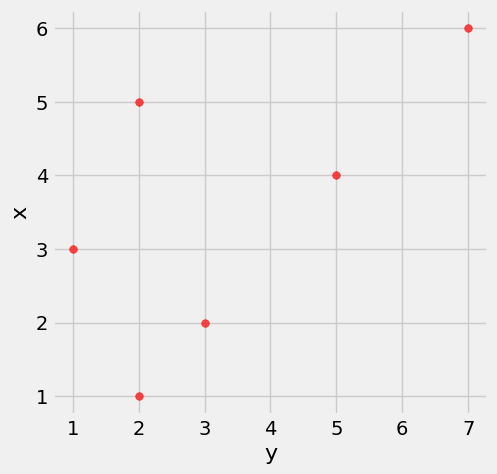

In [21]:
t.scatter('y', 'x', s=30, color='red')

## The `correlation` function
We are going to be calculating correlations repeatedly, so it will help to define a function that computes it by performing all the steps described above. Let's define a function ``correlation`` that takes a table and the labels of two columns in the table. The function returns $r$, the mean of the products of those column values in standard units.

In [22]:
def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

Let's call the function on the ``x`` and ``y`` columns of ``t``. The function returns the same answer to the correlation between $x$ and $y$ as we got by direct application of the formula for $r$. 

In [23]:
correlation(t, 'x', 'y')

0.61741639718977093

As we noticed, the order in which the variables are specified doesn't matter.

In [24]:
correlation(t, 'y', 'x')

0.61741639718977093

Calling ``correlation`` on columns of the table ``suv`` gives us the correlation between price and mileage as well as the correlation between price and acceleration.

In [25]:
correlation(suv, 'mpg', 'msrp')

-0.6667143635709919

In [26]:
correlation(suv, 'acceleration', 'msrp')

0.48699799279959155

These values confirm what we had observed: 

- There is a negative association between price and efficiency, whereas the association between price and acceleration is positive.
- The linear relation between price and acceleration is a little weaker (correlation about 0.5) than between price and mileage (correlation about -0.67). 

Correlation is a simple and powerful concept, but it is sometimes misused. Before using $r$, it is important to be aware of what correlation does and does not measure.

## Association is not Causation

Correlation only measures association. Correlation does not imply causation. Though the correlation between the weight and the math ability of children in a school district may be positive, that does not mean that doing math makes children heavier or that putting on weight improves the children's math skills. Age is a confounding variable: older children are both heavier and better at math than younger children, on average.

## Correlation Measures *Linear* Association
Correlation measures only one kind of association – linear. Variables that have strong non-linear association might have very low correlation. Here is an example of variables that have a perfect quadratic relation $y = x^2$ but have correlation equal to 0.

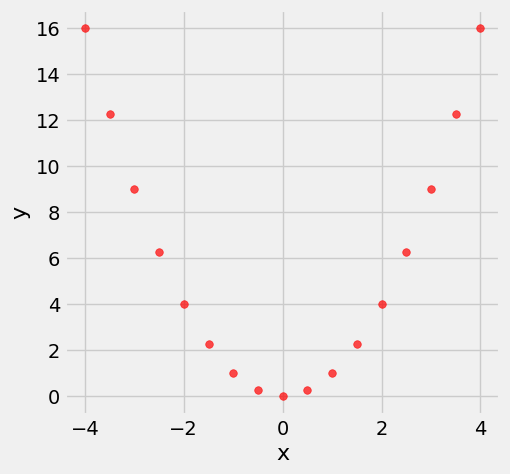

In [27]:
new_x = np.arange(-4, 4.1, 0.5)
nonlinear = Table().with_columns(
        'x', new_x,
        'y', new_x**2
    )
nonlinear.scatter('x', 'y', s=30, color='r')

In [28]:
correlation(nonlinear, 'x', 'y')

0.0

## Correlation is Affected by Outliers
Outliers can have a big effect on correlation. Here is an example where a scatter plot for which $r$ is equal to 1 is turned into a plot for which $r$ is equal to 0, by the addition of just one outlying point.

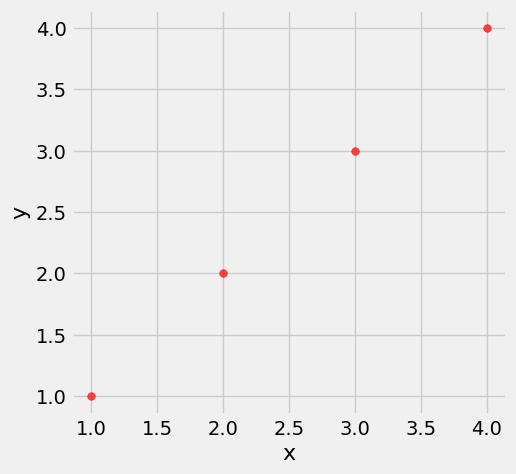

In [29]:
line = Table().with_columns(
        'x', make_array(1, 2, 3, 4),
        'y', make_array(1, 2, 3, 4)
    )
line.scatter('x', 'y', s=30, color='r')

In [30]:
correlation(line, 'x', 'y')

1.0

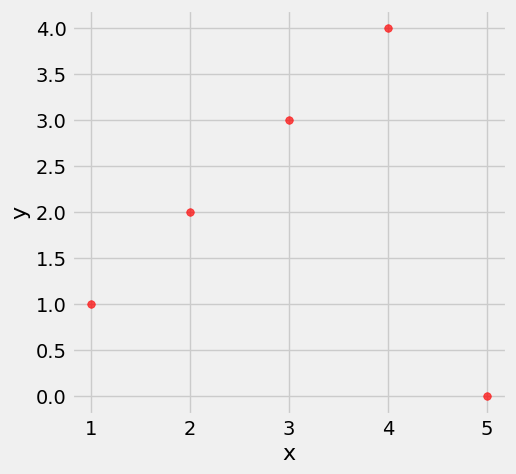

In [31]:
outlier = Table().with_columns(
        'x', make_array(1, 2, 3, 4, 5),
        'y', make_array(1, 2, 3, 4, 0)
    )
outlier.scatter('x', 'y', s=30, color='r')

In [32]:
correlation(outlier, 'x', 'y')

0.0

## Ecological Correlations Should be Interpreted with Care
Correlations based on aggregated data can be misleading. As an example, here are data on the Critical Reading and Math SAT scores in 2014. There is one point for each of the 50 states and one for Washington, D.C. The column ``Participation Rate`` contains the percent of high school seniors who took the test. The next three columns show the average score in the state on each portion of the test, and the final column is the average of the total scores on the test.

In [33]:
sat2014 = Table.read_table(path_data + 'sat2014.csv').sort('State')
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
Alabama,6.7,547,538,532,1617
Alaska,54.2,507,503,475,1485
Arizona,36.4,522,525,500,1547
Arkansas,4.2,573,571,554,1698
California,60.3,498,510,496,1504
Colorado,14.3,582,586,567,1735
Connecticut,88.4,507,510,508,1525
Delaware,100,456,459,444,1359
District of Columbia,100,440,438,431,1309
Florida,72.2,491,485,472,1448


The scatter diagram of Math scores versus Critical Reading scores is very tightly clustered around a straight line; the correlation is close to 0.985. 

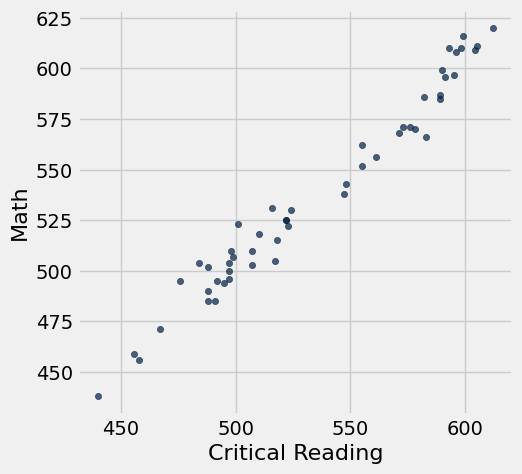

In [34]:
sat2014.scatter('Critical Reading', 'Math')

In [35]:
correlation(sat2014, 'Critical Reading', 'Math')

0.98475584110674341

That's an extremely high correlation. But it's important to note that this does not reflect the strength of the relation between the Math and Critical Reading scores of *students*. 

The data consist of average scores in each state. But states don't take tests – students do. The data in the table have been created by lumping all the students in each state into a single point at the average values of the two variables in that state. But not all students in the state will be at that point, as students vary in their performance. If you plot a point for each student instead of just one for each state, there will be a cloud of points around each point in the figure above. The overall picture will be more fuzzy. The correlation between the Math and Critical Reading scores of the students will be *lower* than the value calculated based on state averages.

Correlations based on aggregates and averages are called *ecological correlations* and are frequently reported. As we have just seen, they must be interpreted with care.

## Serious or tongue-in-cheek?

In 2012, a [paper](http://www.biostat.jhsph.edu/courses/bio621/misc/Chocolate%20consumption%20cognitive%20function%20and%20nobel%20laurates%20%28NEJM%29.pdf) in the respected New England Journal of Medicine examined the relation between chocolate consumption and Nobel Prizes in a group of countries. The [Scientific American](http://blogs.scientificamerican.com/the-curious-wavefunction/chocolate-consumption-and-nobel-prizes-a-bizarre-juxtaposition-if-there-ever-was-one/) responded seriously whereas
[others](http://www.reuters.com/article/2012/10/10/us-eat-chocolate-win-the-nobel-prize-idUSBRE8991MS20121010#vFdfFkbPVlilSjsB.97) were more relaxed. You are welcome to make your own decision! The following graph, provided in the paper, should motivate you to go and take a look.

In [36]:
from IPython.display import Image
Image("../../../images/chocoNobel.png")

FileNotFoundError: No such file or directory: '../../../images/chocoNobel.png'

FileNotFoundError: No such file or directory: '../../../images/chocoNobel.png'

<IPython.core.display.Image object>